In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/content/MtHoodMeadows.csv",
                 index_col="Date.Time..PST.", parse_dates=True)
df=df.drop('Unnamed: 0', axis=1)
df=df.rename(columns={'Relative.Humidity......':'Humidity',
                      'Temperature...deg.F..':'Temperature',
                      'Wind.Direction...deg...':'Wind_direction',
                      'Wind.Speed.Average...mph..':'Wind_speed_avg',
                      'Wind.Speed.Maximum...mph..':'Wind_speed_max',
                      'Wind.Speed.Minimum...mph..':'Wind_speed_min'})
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].mean())
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())
df['Wind_direction'] = df['Wind_direction'].fillna(df['Wind_direction'].mean())
df['Wind_speed_avg'] = df['Wind_speed_avg'].fillna(df['Wind_speed_avg'].mean())
df['Wind_speed_max'] = df['Wind_speed_max'].fillna(df['Wind_speed_max'].mean())
df['Wind_speed_min'] = df['Wind_speed_min'].fillna(df['Wind_speed_min'].mean())

<Axes: xlabel='Date.Time..PST.'>

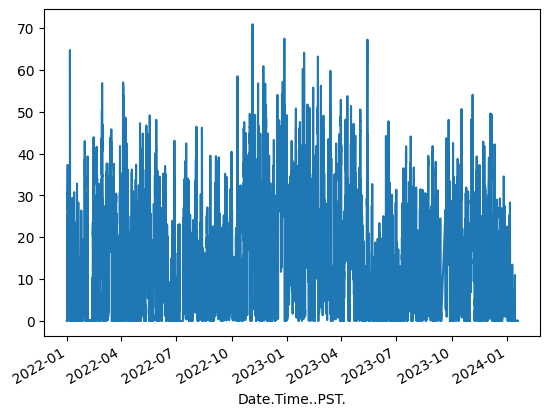

In [21]:
temp = df['Temperatute']
temp.plot()

In [22]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [24]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((17718, 5, 1), (17718,))

In [25]:
X_train1, y_train1 = X1[:14000], y1[:14000]
X_val1, y_val1 = X1[14000:16000], y1[14000:16000]
X_test1, y_test1 = X1[16000:], y1[16000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((14000, 5, 1), (14000,), (2000, 5, 1), (2000,), (1718, 5, 1), (1718,))

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
438/438 [==============================] - 9s 16ms/step - loss: 316.1079 - root_mean_squared_error: 17.7794 - val_loss: 241.8689 - val_root_mean_squared_error: 15.5521
Epoch 2/10
438/438 [==============================] - 7s 15ms/step - loss: 180.5512 - root_mean_squared_error: 13.4369 - val_loss: 146.1495 - val_root_mean_squared_error: 12.0892
Epoch 3/10
438/438 [==============================] - 7s 16ms/step - loss: 123.6279 - root_mean_squared_error: 11.1188 - val_loss: 103.5703 - val_root_mean_squared_error: 10.1770
Epoch 4/10
438/438 [==============================] - 6s 14ms/step - loss: 92.8912 - root_mean_squared_error: 9.6380 - val_loss: 76.1864 - val_root_mean_squared_error: 8.7285
Epoch 5/10
438/438 [==============================] - 6s 14ms/step - loss: 70.9189 - root_mean_squared_error: 8.4213 - val_loss: 56.0347 - val_root_mean_squared_error: 7.4856
Epoch 6/10
438/438 [==============================] - 7s 17ms/step - loss: 55.6468 - root_mean_squared_error: 7.4

In [29]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [30]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

438/438 [==============================] - 2s 2ms/step


Train Predictions  Actuals
0               0.627661    0.023
1               0.624605    0.029
2               0.630210    0.029
3               0.631141    0.027
4               0.630798    0.026
...                  ...      ...
13995          24.819143   22.450
13996          21.392628   21.360
13997          21.031523   19.530
13998          18.964451   12.990
13999          12.069719    5.607

[14000 rows x 2 columns]

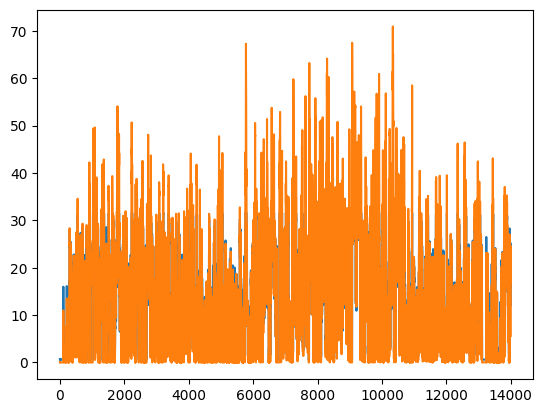

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [32]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

63/63 [==============================] - 0s 2ms/step


Val Predictions  Actuals
0            5.727908    9.820
1           11.061832    4.383
2            4.776929    9.470
3           10.750349   14.400
4           15.709105   18.660
...               ...      ...
1995        31.256132   41.030
1996        31.494221   40.410
1997        31.527922   39.500
1998        31.526989   43.740
1999        31.545238   40.900

[2000 rows x 2 columns]

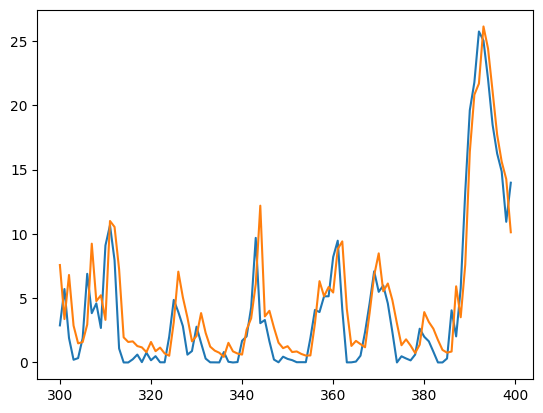

In [33]:
plt.plot(val_results['Actuals'][300:400])
plt.plot(val_results['Val Predictions'][300:400])

In [34]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

54/54 [==============================] - 0s 2ms/step


Test Predictions  Actuals
0            31.540565   37.900
1            31.517141   29.740
2            30.704319   29.340
3            28.926762   19.910
4            18.889244   22.760
...                ...      ...
1713          0.553137    0.001
1714          0.595047    0.000
1715          0.594812    0.000
1716          0.595692    0.000
1717          0.596675    0.000

[1718 rows x 2 columns]

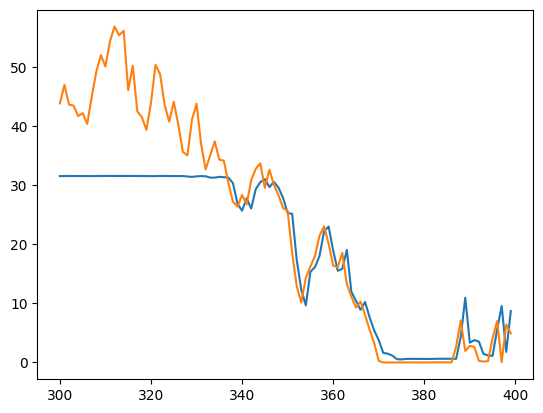

In [35]:
plt.plot(test_results['Test Predictions'][300:400])
plt.plot(test_results['Actuals'][300:400])

In [ ]:
# Split

In [83]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

54/54 [==============================] - 0s 3ms/step


(      Predictions  Actuals
 0       50.832706    63.87
 1       50.860508    52.06
 2       50.624901    49.40
 3       49.411716    49.96
 4       48.551716    38.23
 ...           ...      ...
 1713     1.899797     0.07
 1714     1.222992     0.00
 1715     1.152726     0.00
 1716     1.117414     0.00
 1717     1.101030     0.00
 
 [1718 rows x 2 columns],
 42.38288368376994)

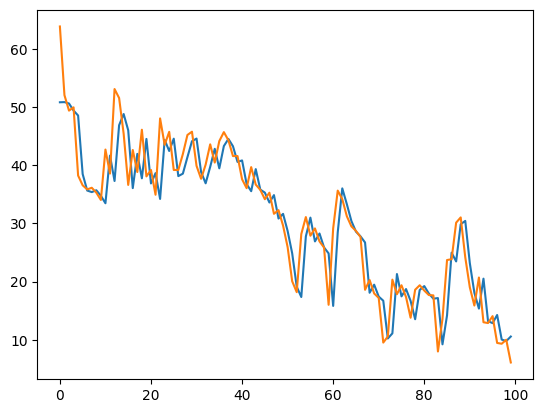

In [84]:
plot_predictions1(model1, X_test1, y_test1)

In [85]:
def predict_next_24(model, X_test):
    initial_data = X_test[-24:]
    predicted_values = []

    for i in range(24):
        # Предсказание следующего значения
        next_value = model.predict(initial_data.reshape(1, 120, 1))
        # Добавление предсказанного значения в список
        predicted_values.append(next_value[0, 0])
        # Обновление initial_data использованием предсказанного значения в следующей итерации
        initial_data = np.roll(initial_data, -1)
        initial_data[-1] = next_value

    return predicted_values

In [86]:
def predict_next_N_days(model, X_test, N):
    predicted_values_N_days = []

    # Цикл для прогнозирования N дней вперед, используя функцию predict_next_24
    for day in range(N):
        # Предсказание значений на 24 часа вперед
        predicted_24h = predict_next_24(model, X_test)
        # Добавление предсказанных значений на 24 часа в список для дней
        predicted_values_N_days.extend(predicted_24h)
        predicted_24h=pd.DataFrame(predicted_24h, columns=['Data'])
        X1, y1 = df_to_X_y(predicted_24h['Data'], WINDOW_SIZE)
        # Обновление X_test для использования предсказанных значений в следующей итерации
        X_test = np.concatenate((X_test, X1))

    return predicted_values_N_days


In [87]:
pred=predict_next_N_days(model1, X_test1, 13)

1/1 [==============================] - 0s 26ms/step


In [88]:
predicted_series = pd.Series(pred, index=pd.date_range(start='2024-01-18 02:00:00', periods=len(pred), freq='H'))

# Выводим результат
df_predicted = pd.DataFrame({'Predicted_Values': predicted_series})

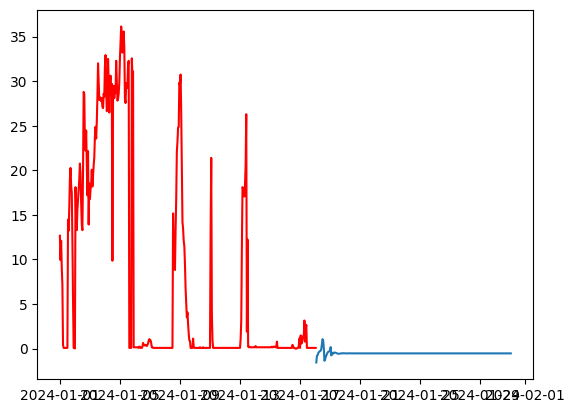

In [90]:
plt.plot(df.Wind_speed_max['2024-01-01':], color='red')
plt.plot(df_predicted)

In [91]:
df_predicted.to_excel("/content/Wind_speed_max.xlsx", encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


In [92]:
data=pd.read_excel("/content/Wind_speed_max.xlsx")


In [66]:
data

Unnamed: 0  Predicted_Values
0   2024-01-18 02:00:00         -0.582889
1   2024-01-18 03:00:00         -0.472023
2   2024-01-18 04:00:00         -0.467122
3   2024-01-18 05:00:00         -0.449566
4   2024-01-18 06:00:00         -0.436427
..                  ...               ...
307 2024-01-30 21:00:00         -0.388280
308 2024-01-30 22:00:00         -0.388280
309 2024-01-30 23:00:00         -0.388280
310 2024-01-31 00:00:00         -0.388280
311 2024-01-31 01:00:00         -0.388280

[312 rows x 2 columns]